# **Data modeling lab proyect - Regression**

- Diego Octavio Perez Urbina
- Jose Luis Almendarez Gonzalez
- Patricio Adulfo Villanueva Gio

## **1. Data definition** ##

This is a dataset that combines socio-economic data from the 1990 US Census,law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR. The objective of this proyect is to predict **violent crimes per capita** ("ViolentCrimesPerPop") in each US community from the dataset. 

Some thing to take into consideration before reading this notebook: 

- There are some location features like: **state**, **county**, **community**, **communityname** that won't be used to predict because that may perpetuate bias against certain communities. 
- Because the objective feature is **per Capita** we'll try to create relative values to the total community population, so the size of the community and their absolute values don't biase the algorithm. For example: **Number of sworn full-time police officers in field operations** will be change to **Number of sworn full-time police officers in field operations per capita**
- **Fold** feature wont be used.
- All demographics porcentages, means and medians are from each community, because the dataset granularity is by communities
- **RacialMatchCommPol** is the measure of the racial match between the community and the police force. High values indicate proportions in the community and police force are similar
- **LemasGangUnitDeploy** Encoding:
    - No unit = 0
    - There's unit = 1
    - Part time unit = 0.5

For detailed description of each feature run the code below

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Run this code below to see all columns name and their meaning
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 130)
pd.read_csv('columns.csv')

,Feature,Type,Description
0,state,numeric,"US state (by number) - not counted as predictive above, but if considered, should be considered nominal (nominal)"
1,county,numeric,"Numeric code for county - not predictive, and many missing values (numeric)"
2,community,numeric,Numeric code for community - not predictive and many missing values (numeric)
3,communityname,string,Community name - not predictive - for information only (string)
4,fold,numeric,"Fold number for non-random 10-fold cross-validation, potentially useful for debugging, paired tests - not predictive (numeric)"
5,population,numeric,Population for the community (numeric - decimal)
6,householdsize,numeric,Mean people per household (numeric - decimal)
7,racepctblack,numeric,Percentage of the population that is African American (numeric - decimal)
8,racePctWhite,numeric,Percentage of the population that is Caucasian (numeric - decimal)
9,racePctAsian,numeric,Percentage of the population that is of Asian heritage (numeric - decimal)


In [3]:
#df.drop(['state', 'county','community','communityname','fold'], axis = 'columns', inplace=True)

In [4]:
columns = pd.read_csv('columns.csv').Feature.to_list()

with open('communities.data', 'r') as file:
    data = []
    for line in file:
        row = line.strip().split(',')
        data.append(row)


df = pd.DataFrame(data,columns=columns)

In [5]:
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.9,0.12,...,0.12,0.26,0.2,0.06,0.04,0.9,0.5,0.32,0.14,0.2
1,53,?,?,Tukwilacity,1,0,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0,?,0.67
2,24,?,?,Aberdeentown,1,0,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0,?,0.03


## **2. Data Preparation** ##

In [6]:
(df.isna().sum() > 0).sum()

0

Seems like there are no nulls, but let's see if this is true

In [7]:
#Converting object columns to their correct type
colsWithErrors = []
for col in [col for col in df.columns if col not in ('state','county','community','communityname','fold')]:
    try:
        df[col] = df[col].astype('float64')

    except Exception as e:
        colsWithErrors.append(col)
        print(f"Column - {col} had the following problem: {e}")


Column - OtherPerCap had the following problem: could not convert string to float: '?'
Column - LemasSwornFT had the following problem: could not convert string to float: '?'
Column - LemasSwFTPerPop had the following problem: could not convert string to float: '?'
Column - LemasSwFTFieldOps had the following problem: could not convert string to float: '?'
Column - LemasSwFTFieldPerPop had the following problem: could not convert string to float: '?'
Column - LemasTotalReq had the following problem: could not convert string to float: '?'
Column - LemasTotReqPerPop had the following problem: could not convert string to float: '?'
Column - PolicReqPerOffic had the following problem: could not convert string to float: '?'
Column - PolicPerPop had the following problem: could not convert string to float: '?'
Column - RacialMatchCommPol had the following problem: could not convert string to float: '?'
Column - PctPolicWhite had the following problem: could not convert string to float: '?'
C

In [8]:
df.replace({"?":np.nan},inplace=True)

In [9]:
for col in colsWithErrors:
    df[col] = df[col].astype('float64')

Now let's see how many null do we have

In [10]:
nulls = pd.DataFrame(df.isna().sum(),columns=["amount"])
nulls = nulls.loc[nulls.amount > 0].sort_values(by="amount",ascending=False)
nulls["nullPercentage"] = round((nulls.amount / df.shape[0])*100,2)
nulls

,amount,nullPercentage
PctPolicWhite,1675,84.00
PctPolicBlack,1675,84.00
LemasGangUnitDeploy,1675,84.00
LemasPctPolicOnPatr,1675,84.00
PolicOperBudg,1675,84.00
PolicCars,1675,84.00
PolicAveOTWorked,1675,84.00
NumKindsDrugsSeiz,1675,84.00
OfficAssgnDrugUnits,1675,84.00
PctPolicMinor,1675,84.00


Discovering data behavior

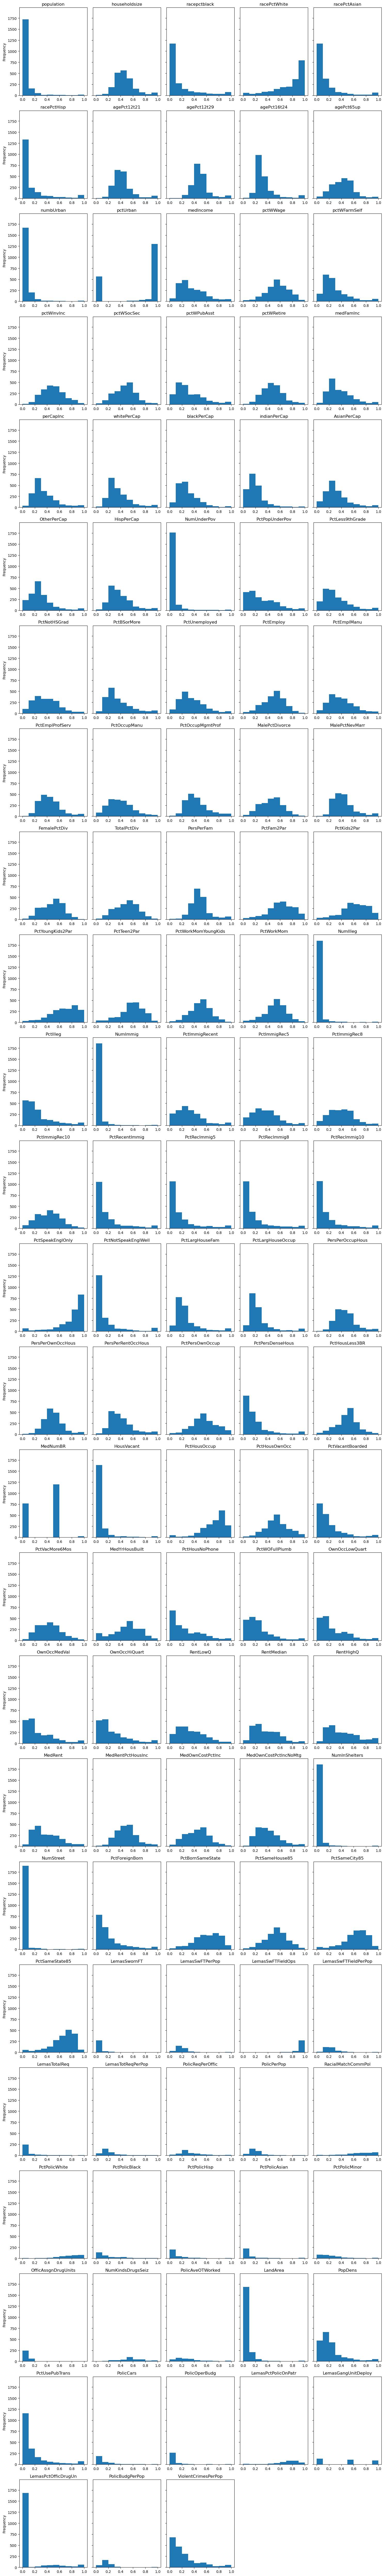

In [11]:

numerical_cols = df.select_dtypes(include=['number']).columns

# Calculate the number of rows 
num_features = len(numerical_cols)
num_cols = 5
num_rows = (num_features - 1) // num_cols + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), sharey=True)  # Adjust the figsize as needed
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(numerical_cols):
    ax = axes[i]
    df[col].plot(kind='hist', ax=ax, bins=10) 
    ax.set_title(col)

# Remove any empty subplots if the number of features is not a multiple of 5
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Will be easier to look at the histograms of the features with the most correlation with the objective field

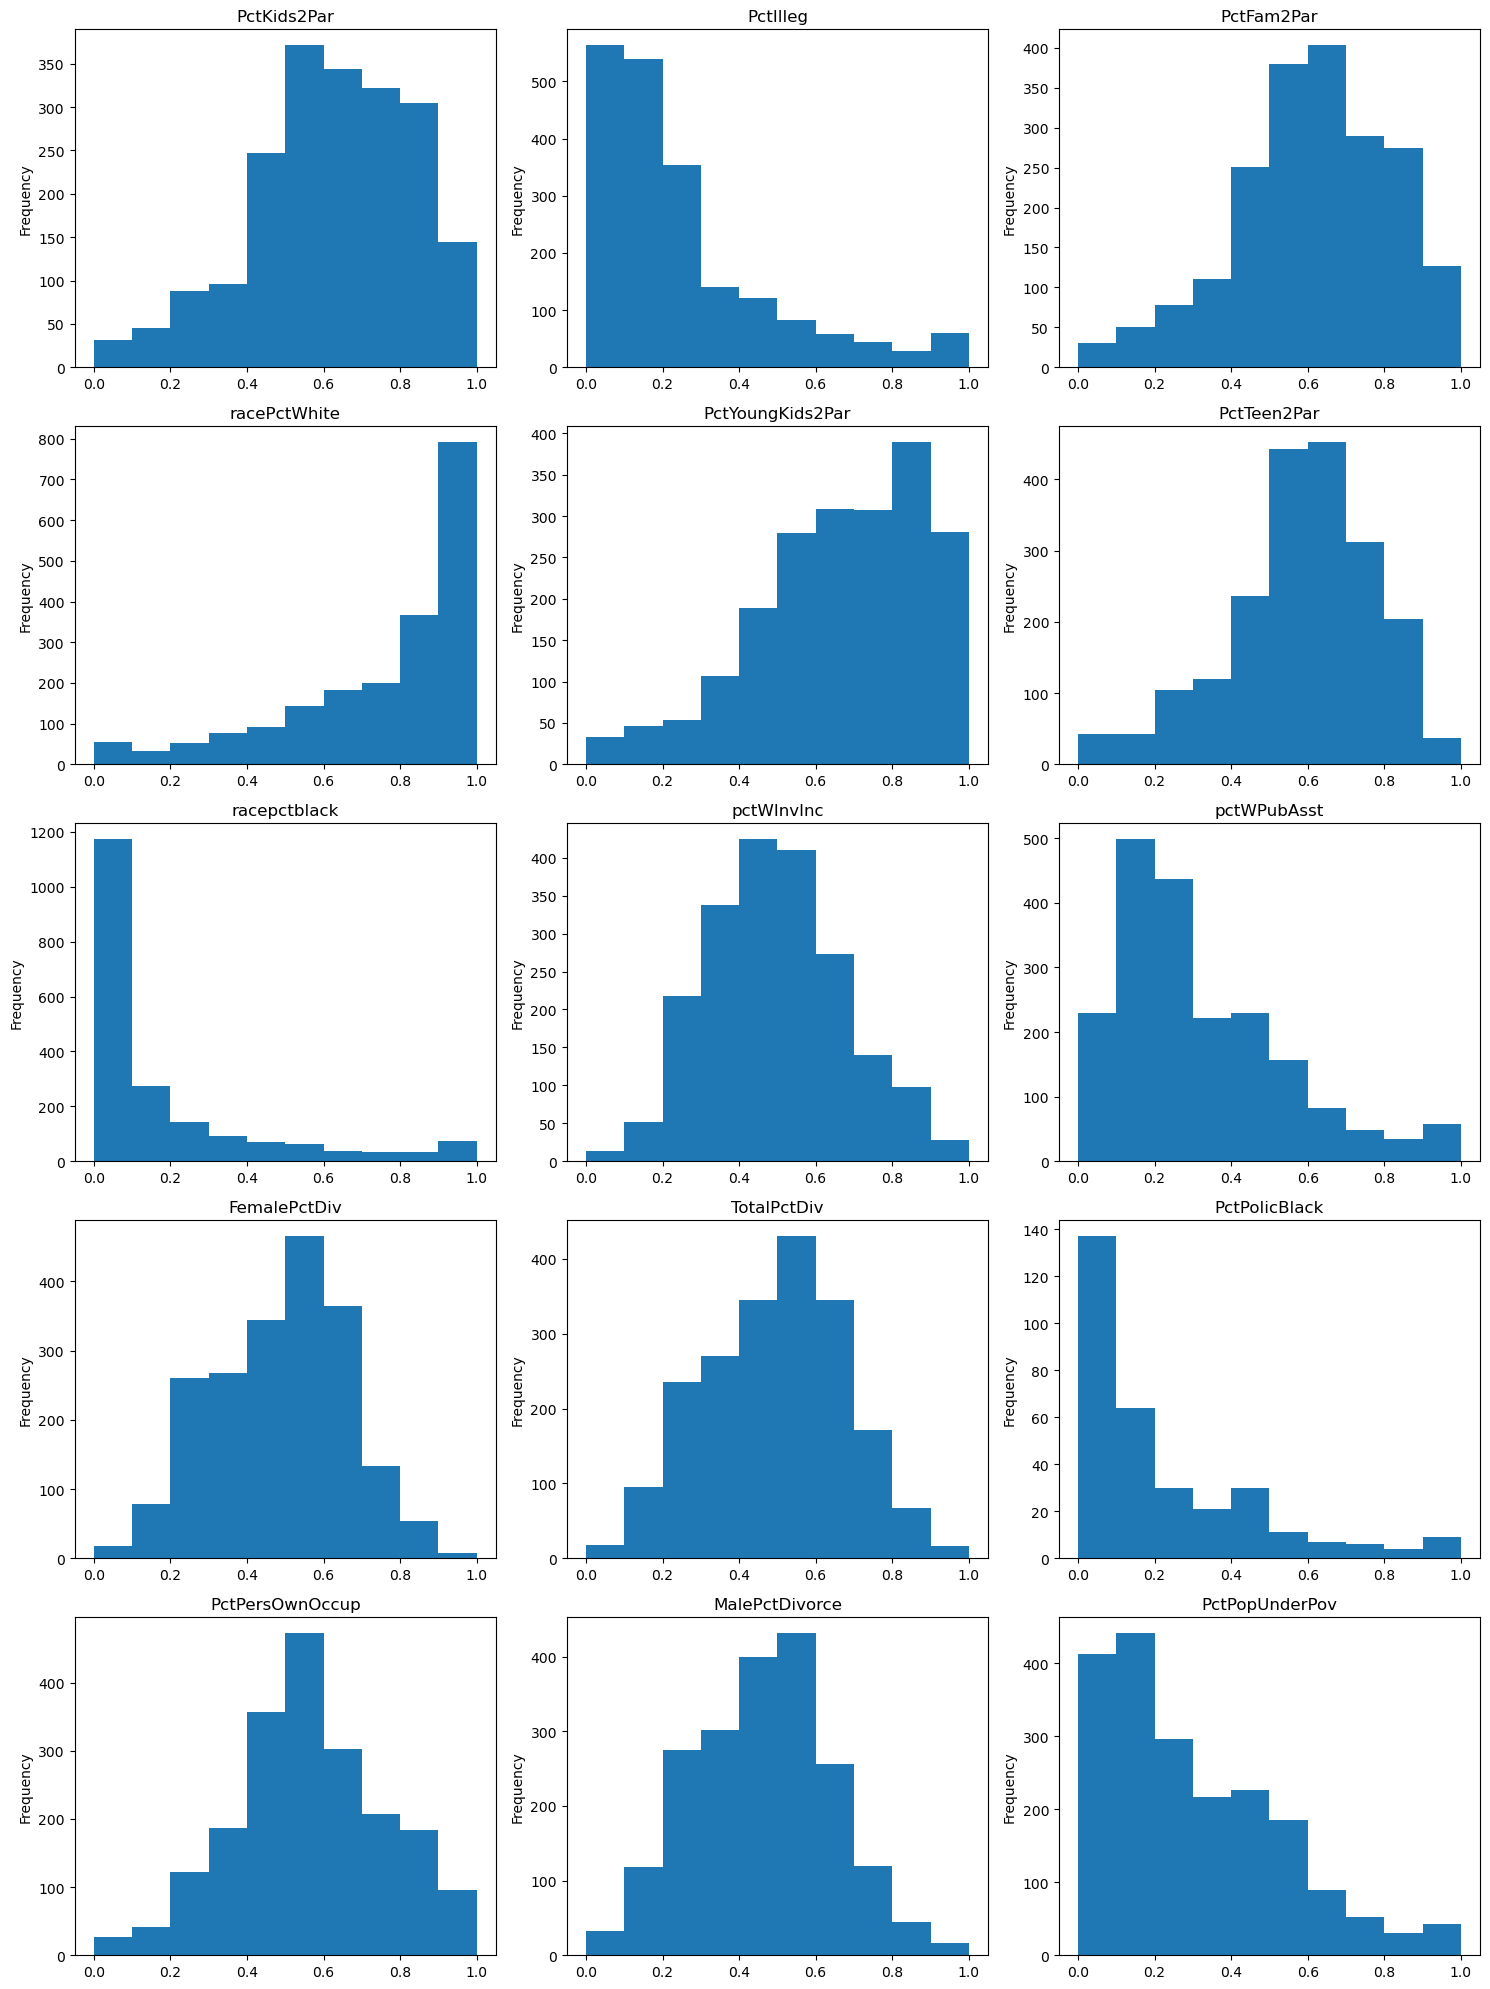

In [12]:
mostCorrelated = pd.DataFrame(abs(df.corr(numeric_only=True)
                 ['ViolentCrimesPerPop']).sort_values(ascending=False)[1:16] #First 15 features
                 ).index


numerical_cols = df[mostCorrelated].select_dtypes(include=['number']).columns

# Calculate the number of rows and columns needed for the grid
num_features = len(numerical_cols)
num_rows = (num_features - 1) // 3 + 1
num_cols = min(num_features, 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))  # Adjust the figsize as needed

# Flatten the 2D array of subplots
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(numerical_cols):
    ax = axes[i]
    df[col].plot(kind='hist', ax=ax, bins=10)  # Adjust the number of bins as needed
    ax.set_title(col)

# Remove any empty subplots if the number of features is not a multiple of 3
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [13]:
df.drop(['state', 'county','community','communityname','fold'], axis = 'columns', inplace=True)

In [14]:
mode_opc = df['OtherPerCap'].mode().values[0]
df['OtherPerCap'].fillna(mode_opc, inplace=True)

In [15]:
df['LemasGangUnitDeploy'].fillna(0, inplace=True)

In [16]:
df['RacialMatchCommPol'].fillna(0, inplace=True)

In [17]:
null_columns = df.columns[df.isnull().sum() > 0]
df = df.drop(columns=null_columns)
df

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctSameHouse85,PctSameCity85,PctSameState85,RacialMatchCommPol,LandArea,PopDens,PctUsePubTrans,LemasGangUnitDeploy,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.50,0.51,0.64,0.94,0.12,0.26,0.20,0.5,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.34,0.60,0.52,0.00,0.02,0.12,0.45,0.0,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.54,0.67,0.56,0.00,0.01,0.21,0.02,0.0,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.73,0.64,0.65,0.00,0.02,0.39,0.28,0.0,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.64,0.61,0.53,0.00,0.04,0.09,0.02,0.0,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.34,0.48,0.39,0.00,0.01,0.28,0.05,0.0,0.00,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.17,0.10,0.00,0.00,0.02,0.37,0.20,0.0,0.00,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.61,0.79,0.76,0.97,0.08,0.32,0.18,0.0,0.91,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.54,0.59,0.52,0.91,0.03,0.38,0.33,0.0,0.22,0.19


In [18]:
df.shape

(1994, 103)

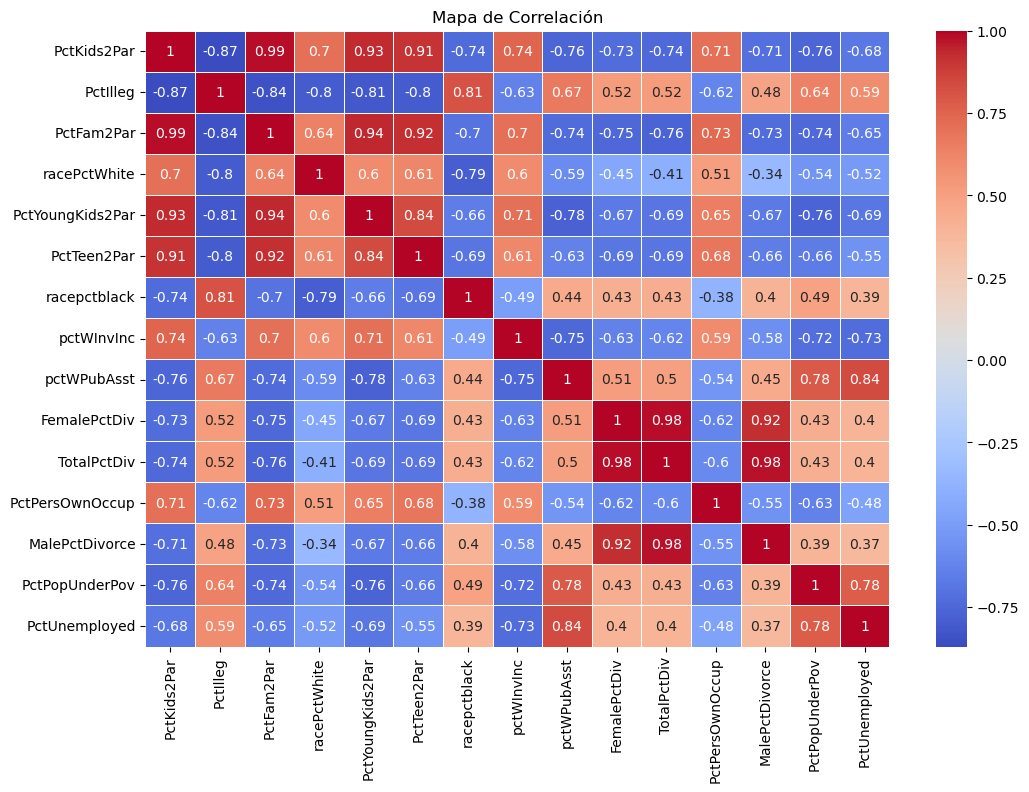

In [19]:
import seaborn as sns

mostCorrelated = pd.DataFrame(abs(df.corr(numeric_only=True)['ViolentCrimesPerPop']).sort_values(ascending=False)[1:16]).index
correlation_df = df[mostCorrelated]
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Mapa de Correlación')
plt.show()

In [20]:
correlation_with_response = df.corr()['ViolentCrimesPerPop'].abs()
correlation_with_response = correlation_with_response.sort_values(ascending=False)
correlation_with_response

ViolentCrimesPerPop      1.000000
PctKids2Par              0.738424
PctIlleg                 0.737957
PctFam2Par               0.706667
racePctWhite             0.684770
PctYoungKids2Par         0.666059
PctTeen2Par              0.661582
racepctblack             0.631264
pctWInvInc               0.576324
pctWPubAsst              0.574665
FemalePctDiv             0.556032
TotalPctDiv              0.552777
PctPersOwnOccup          0.525491
MalePctDivorce           0.525407
PctPopUnderPov           0.521877
PctUnemployed            0.504235
PctHousNoPhone           0.488243
PctNotHSGrad             0.483366
PctVacantBoarded         0.482816
PctHousLess3BR           0.474490
NumIlleg                 0.471028
PctHousOwnOcc            0.470683
PctPersDenseHous         0.452901
NumUnderPov              0.447582
medFamInc                0.439108
medIncome                0.424221
HousVacant               0.421396
PctLess9thGrade          0.411096
PctLargHouseFam          0.383480
NumInShelters 

In [21]:
df.to_csv('cleanedData.csv')